In [26]:
#1

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

import numpy as np
from tqdm.auto import tqdm
import glob

import torch.autograd as autograd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import PackedSequence

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
#2

import os
import pandas as pd
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.nn import functional as F

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score


In [28]:
#3

class ActivationDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [29]:
#4

AVAandWTStim = os.path.join('.', 'DatasetsTest', 'AVA&WTStim', '*.csv')

def data_selection(datasetPath, testDatasetName):
    csv_files = glob.glob(datasetPath)
    
    testDataPath = ""
    for i in range(len(csv_files)):
        if testDatasetName in csv_files[i]:
            testDataPath = csv_files[i]
            break
            
    newTrainingFiles = [trainFile for trainFile in csv_files if trainFile != testDataPath]
        
    return newTrainingFiles, testDataPath

testFileName = "WT_Stim1"
#testFileName = "AVA_HisCl2"
trainingFiles, testFile = data_selection(AVAandWTStim, testFileName)
print(trainingFiles)
print(testFile)

allDatasetsTrain = []
allDatasetsTest = []

['.\\DatasetsTest\\AVA&WTStim\\AVA_HisCl1.csv', '.\\DatasetsTest\\AVA&WTStim\\AVA_HisCl2.csv', '.\\DatasetsTest\\AVA&WTStim\\AVA_HisCl3.csv', '.\\DatasetsTest\\AVA&WTStim\\AVA_HisCl4.csv', '.\\DatasetsTest\\AVA&WTStim\\AVA_HisCl5.csv', '.\\DatasetsTest\\AVA&WTStim\\WT_Stim2.csv', '.\\DatasetsTest\\AVA&WTStim\\WT_Stim3.csv', '.\\DatasetsTest\\AVA&WTStim\\WT_Stim4.csv', '.\\DatasetsTest\\AVA&WTStim\\WT_Stim5.csv', '.\\DatasetsTest\\AVA&WTStim\\WT_Stim6.csv', '.\\DatasetsTest\\AVA&WTStim\\WT_Stim7.csv']
.\DatasetsTest\AVA&WTStim\WT_Stim1.csv


In [30]:
#5

"""
Data processing for MLP model

Arguments:
    csv files: path to the csv files

Returns:
    Concatenated datasets. Since there is no implementation for tracking time dependencies in feed forward networks,
    the datasets are all appended together creating one big dataset
"""

for file in trainingFiles:
    data = pd.read_csv(file)

    X = data.iloc[:, :-1]
    #Subtracting one to make labels in range of what the model can accept (0-3)
    y = data.iloc[:, -1] - 1
    
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)

    XTrain = torch.tensor(XTrain.values, dtype=torch.float)
    yTrain = torch.tensor(yTrain.to_numpy(), dtype=torch.long)

    XTest = torch.tensor(XTest.values, dtype=torch.float)
    yTest = torch.tensor(yTest.to_numpy(), dtype=torch.long)

    allDatasetsTrain.append(ActivationDataset(XTrain, yTrain))
    allDatasetsTest.append(ActivationDataset(XTest, yTest))

fullDatasetTrain = ConcatDataset(allDatasetsTrain)
fullDatasetTest = ConcatDataset(allDatasetsTest)

dataloaderTrain = DataLoader(fullDatasetTrain, batch_size=32, shuffle=True)
dataloaderTest = DataLoader(fullDatasetTest, batch_size=32, shuffle=False)

In [31]:
#6

class MLP(nn.Module):
    def __init__(self, input_size, n_classes):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )
        
    def forward(self, x):
        return self.layers(x)

model = MLP(XTrain.shape[1], 4)
model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=134, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [21]:
#7

train_losses = []
val_losses = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MLP(XTrain.shape[1], 4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

nepochs = 30
for epoch in range(nepochs):
    model.train()
    for i, (XBatch, yBatch) in enumerate(dataloaderTrain):
        XBatch, yBatch = XBatch.to(device), yBatch.to(device)
        optimizer.zero_grad()
        outputs = model(XBatch)
        loss = criterion(outputs, yBatch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    for XBatch, yBatch in dataloaderTest:
        XBatch, yBatch = XBatch.to(device), yBatch.to(device)
        outputs = model(XBatch)
        val_loss += criterion(outputs, yBatch).item()

    val_loss /= len(dataloaderTest)

    print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, nepochs, loss.item(), val_loss))
    train_losses.append(loss.item())
    val_losses.append(val_loss)

Path = os.path.join('.', 'Saved_Models', testFileName + '_MLP')
#Uncomment line below to start saving models
#torch.save(model, Path)

Epoch [1/30], Training Loss: 1.4750, Validation Loss: 0.3284
Epoch [2/30], Training Loss: 0.0002, Validation Loss: 0.2761
Epoch [3/30], Training Loss: 0.0875, Validation Loss: 0.2620
Epoch [4/30], Training Loss: 0.0251, Validation Loss: 0.2422
Epoch [5/30], Training Loss: 0.6135, Validation Loss: 0.2376
Epoch [6/30], Training Loss: 0.0000, Validation Loss: 0.2301
Epoch [7/30], Training Loss: 0.0000, Validation Loss: 0.2110
Epoch [8/30], Training Loss: 0.0001, Validation Loss: 0.2065
Epoch [9/30], Training Loss: 0.0127, Validation Loss: 0.2176
Epoch [10/30], Training Loss: 1.5631, Validation Loss: 0.2049
Epoch [11/30], Training Loss: 0.0006, Validation Loss: 0.2009
Epoch [12/30], Training Loss: 0.6743, Validation Loss: 0.2320
Epoch [13/30], Training Loss: 0.0345, Validation Loss: 0.2217
Epoch [14/30], Training Loss: 0.7729, Validation Loss: 0.2109
Epoch [15/30], Training Loss: 0.1407, Validation Loss: 0.2322
Epoch [16/30], Training Loss: 0.1661, Validation Loss: 0.2692
Epoch [17/30], Tr

In [ ]:
#8

Path = os.path.join('.', 'Saved_Models', testFileName + '_MLP')

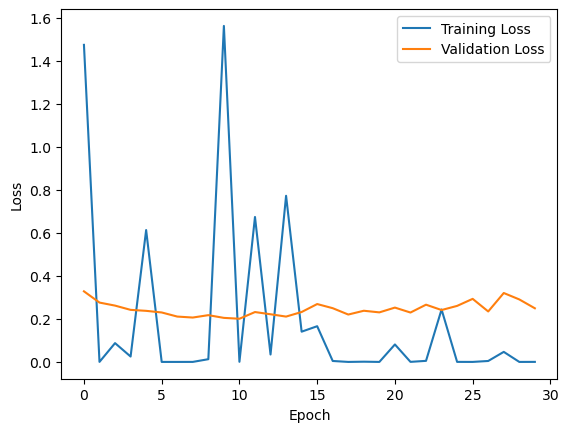

In [22]:
#9

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
#10

df = pd.read_csv(testFile)

In [24]:
#11

def predict_actions(model, dataset):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()  
    predictions = []

    for i in range(len(dataset)):
        sample = torch.tensor(dataset[i], dtype=torch.float32).unsqueeze(0).to(device) 
        output = model(sample)  
        _, predicted = torch.max(output.data, 1) 
        predictions.append(predicted.item() + 1)

    return predictions

model = torch.load(Path)

unlabeledData = df.drop('Action', axis=1).values
predictions = predict_actions(model, unlabeledData)

dfPredictions = pd.DataFrame({"Predicted_Action": predictions})
predictPath = os.path.join('.', 'Predictions', 'MLP_Pred', 'predictions_' + testFileName + '_MLP-FINAL.csv')
dfPredictions.to_csv(predictPath, index=False)

Accuracy: 34.19%
Precision: 69.44%
F1 Score: 40.98%


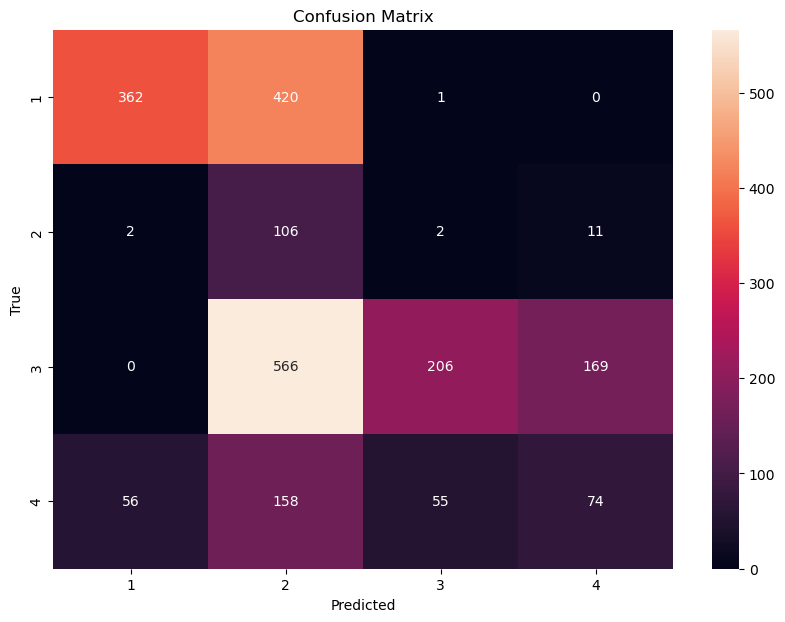

In [25]:
#12

def compare_predictions(trueDF, predictedDF):
    count = 0
    total = 0

    trueDF = trueDF.iloc[10:]
    predictedDF = predictedDF.iloc[10:]

    cmTrueLabels = []
    cmPredictedLabels = []

    for trueLabel, predictedLabel in zip(trueDF['Action'], predictedDF['Predicted_Action']):
        total += 1
        cmTrueLabels.append(trueLabel)
        cmPredictedLabels.append(predictedLabel)
        if trueLabel == predictedLabel:
            count += 1

    accuracy = count / total
    cmTrueLabels = [value + 1 for value in cmTrueLabels]
    cmPredictedLabels = [value + 1 for value in cmPredictedLabels]
    cm = confusion_matrix(cmTrueLabels, cmPredictedLabels)

    precision = precision_score(cmTrueLabels, cmPredictedLabels, average='weighted')
    f1 = f1_score(cmTrueLabels, cmPredictedLabels, average='weighted')

    return accuracy, cm, precision, f1

trueDF = df
predictedDF = pd.read_csv(predictPath)

accuracy, confusion_mat, precision, f1 = compare_predictions(trueDF, predictedDF)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt="d", xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()